![title](assets/flower_banner.jpeg)

# Introduction

In this journal, a machine learning model is used to identify flowers through image classification. This multi-classification model is trained with thousands of images which are randomly augmented to achieve better generalization. The model serves to be a proof of concept in battling invasive plant species that damage the fragile ecosystems in which they reside. This journal will contain the steps taken to arrive at a similar model. Analysis of the results will be mentioned in the later sections, followed by what the results mean for the stakeholder.

# Business Understanding

Every year, the U.S. is estimated to lose $120B due to the impact of invasive plant species. Invasive plant species can reduce yield in nearby agriculture, kill existing plants, increase the risk of forest fires, and much more. While the spread of invasive plant species can be slowed through customs, the plants that reside in U.S. right now need to be found and removed. Programs to remove these plants are already in place, but can be accelerated through the use of machine learning and scouting tools like drones. Drones can quickly scout dangerous terrain and machine learning can rapidly review photos to identify an invasive plant species. This proposal will help reduce cost spent in manual labor and remove the risk of workers traversing dangerous terrain.

### Imports

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
#from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
#from tensorflow.keras.applications import Xception, DenseNet201
from tensorflow.keras.callbacks import LearningRateScheduler
#import random
from PIL import Image
import shutil
import h5py

### Global Variables

In [2]:
# image size options: 192
IMAGE_DIMENSION = 192
VECTOR_LEN = IMAGE_DIMENSION**2
NUM_CLASS = 96

train_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/train'
val_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/val'
test_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/test'

BATCH_SIZE = 64
TRAIN_BATCH_SIZE = BATCH_SIZE
VAL_BATCH_SIZE = BATCH_SIZE
TEST_BATCH_SIZE = BATCH_SIZE

# Data Understanding

### Functions

In [3]:
def get_subfolder_list(source_folder):
    # returns a list of all the subfolders in the source_folder
    class_list_dir = []

    for file in os.listdir(source_folder):
        d = os.path.join(source_folder, file)
        if os.path.isdir(d):
            class_list_dir.append(d)

    return class_list_dir

def map_classes(subfolder_list):
    # returns a dict with the flower as the key, and (count, directory) as the values
    class_dict = {}

    for class_folder in subfolder_list:
        file_count = sum(len(files) for _, _, files in os.walk(class_folder))
        class_dict[class_folder[24:]] = file_count, class_folder
        
    return class_dict

def get_flower_count(class_dict):
    # returns a list of the number of flowers found in the dict
    flower_count = []

    for flower in list(class_dict.values()):
        flower_count.append(flower[0])

    return flower_count

def get_metrics(flower_count):
    # returns basic metrics when given a list of flower value count
    class_std = np.std(flower_count)
    class_max = max(flower_count)
    class_min = min(flower_count)
    class_mean = np.mean(flower_count)
    class_first_quartile = np.percentile(flower_count, 25)
    class_third_quartile = np.percentile(flower_count, 75)
    class_tenth_percentile = np.percentile(flower_count, 10)
    class_fifth_percentile = np.percentile(flower_count, 5)

    print(f'0. standard deviation: {class_std}')
    print(f'1. max: {class_max}')
    print(f'2. min: {class_min}')
    print(f'3. mean: {class_mean}')
    print(f'4. 25%: {class_first_quartile}')
    print(f'5. 75%: {class_third_quartile}')
    print(f'6. 10%: {class_tenth_percentile}')
    print(f'7. 5%: {class_fifth_percentile}')
    
    return (class_std, class_max, class_min, class_mean, class_first_quartile,
class_third_quartile, class_tenth_percentile, class_fifth_percentile)

def plot_distribution(keys, values):
    list1 = list(train_dict.keys())
    list2 = train_flower_count
    
    dict_list = {}

    for i in range(len(list1)):
        dict_list[list1[i]] = list2[i]

    dict_list
    
    df = pd.DataFrame.from_dict(dict_list, orient='index')

    df_sorted = df.sort_values(0, ascending=False)

    flower_name = list(df_sorted.index)
    value_count = list(df_sorted[0])
    
    fig, ax = plt.subplots(figsize=(15, 20))

    ax.barh(flower_name, value_count);
    ax.set_xlabel('# of images')

In [4]:
train_subfolders = get_subfolder_list(train_dir)
train_dict = map_classes(train_subfolders)
train_flower_count = get_flower_count(train_dict)

train_subfolders[:5]

['data/jpeg-192x192/train/toad lily',
 'data/jpeg-192x192/train/love in the mist',
 'data/jpeg-192x192/train/monkshood',
 'data/jpeg-192x192/train/azalea',
 'data/jpeg-192x192/train/fritillary']

In [5]:
get_metrics(train_flower_count)

0. standard deviation: 132.99130714962862
1. max: 707
2. min: 16
3. mean: 111.1826923076923
4. 25%: 30.5
5. 75%: 113.5
6. 10%: 19.0
7. 5%: 17.15


(132.99130714962862, 707, 16, 111.1826923076923, 30.5, 113.5, 19.0, 17.15)

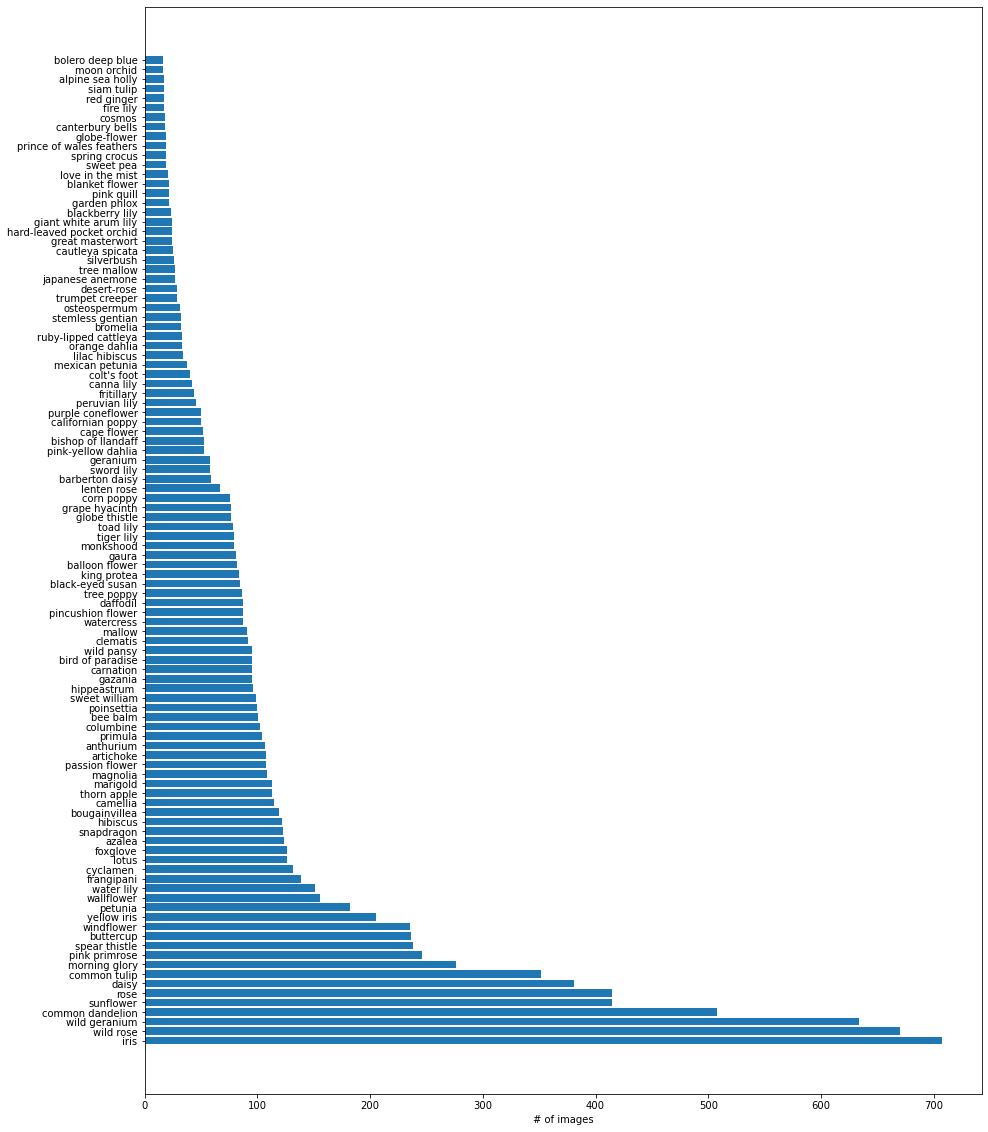

In [6]:
list1 = list(train_dict.keys())
list2 = train_flower_count

plot_distribution(list1, list2)

There are 104 different flower species provided in this dataset, 16,463 images with different compositions. An image can be of a distant rose bush, a macro photo of a sunflower bud, or a portrait with a hibiscus tucked behind the ear. The distribution of these flowers is not equal and would result in some preprocessing before models should be trained.

# Data Preparation

### More functions

In [7]:
def copy_subfolder(source):
    # copies source folder to a new directory with '_new' attached to the end of the folder name
    prev_dir_index = source.rfind('/')
    destination = source[:prev_dir_index] + '_new' + source[prev_dir_index:]
    
    
    if not os.path.exists(destination):
        result = shutil.copytree(source, destination, symlinks=False, ignore=None, 
                                 copy_function=shutil.copy2, ignore_dangling_symlinks=False, 
                                 dirs_exist_ok=False)
    else:
        print(f'{destination} already exists')
        
    return result
    
def item_count(folder):
    # helper function to identify which folders to remove
    file_count = sum(len(files) for _, _, files in os.walk(folder))
    
    return file_count
    
def get_short_list(subfolder_list, n):
    # find a list of classes that are divided by the specified n value
    temp_dict = map_classes(subfolder_list)
    temp_flower_count = get_flower_count(temp_dict)
    
    move_list = []
    ignore_list = []
    
    percent_cutoff = np.percentile(temp_flower_count, n)
    
    remove_count = 0
    
    for subfolder in subfolder_list:
        if item_count(subfolder) >= percent_cutoff:
            move_list.append(subfolder)
        else:
            ignore_list.append(subfolder)
            remove_count += item_count(subfolder)
            
    print(f'removed {remove_count} images')
    
    return move_list, ignore_list
    
def trim(subfolder_list):
    # main function used to copy classes into new train, val, test 
    for subfolder in subfolder_list:
        copy_subfolder(subfolder)

        val_subfolder = subfolder.replace('/train/', '/val/')
        copy_subfolder(val_subfolder)

        test_subfolder = subfolder.replace('/train/', '/test/')
        copy_subfolder(test_subfolder)

The structure of the directory has class labels for the train and validation folder, but the test folder contains images without any labels. To create a typical train, validate, and test structure, the images in the test folder will be ignored from this point on. 10% of the images found in the train folder will be moved into a new test folder, resulting in three folders with labeled images.

In [8]:
move_list, ignore_list = get_short_list(train_subfolders, 10)

removed 136 images


In [9]:
# only needs to be run once if the direectory is not yet set up
trim(move_list)

In [10]:
# updating the directories as new folders are made 
train_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/train_new'
val_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/val_new'
test_dir = f'data/jpeg-{IMAGE_DIMENSION}x{IMAGE_DIMENSION}/test_new'

![resulting directory](assets/directory_after.jpg)

With this directory set up, classes of flowers that do not have enough information on which to train a model can be removed. Functions have been created to select these folders to avoid manually separating the folders by hand. In the models shown in the notebook, the 10th percentile of the number of images found in the training are removed from the scope. This leaves 96 classes with 16,268 images. On average, there should be 168 images per class that can be divided into train, validation, and test sets. 

With nearly 100 different classes, there are not enough images to effectively train a model. Data augmentation will be used to make the model more generalizable. Each image will randomly flip, change in brightness, crop, and many other transformations. Also, with these images being RGB, the images will need to be standardized from 0 and 255 to the range of 0 and 1.

In [11]:
train_generator = ImageDataGenerator(rescale=1./255, 
                                     horizontal_flip=True, 
                                     rotation_range=45,
                                     vertical_flip=False,
                                     brightness_range=[0.75,1.25],
                                     zoom_range=0.2,
                                     shear_range=0.2
                                    ).flow_from_directory(
    train_dir,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION), 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True 
)

val_generator = ImageDataGenerator().flow_from_directory(
    val_dir,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=VAL_BATCH_SIZE,
    shuffle=True
)

test_generator = ImageDataGenerator().flow_from_directory(
    test_dir,
    target_size=(IMAGE_DIMENSION, IMAGE_DIMENSION),
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
)

Found 11331 images belonging to 96 classes.
Found 3666 images belonging to 96 classes.
Found 1271 images belonging to 96 classes.


# Modeling

The first model made is a simple convoluational neural network (CNN) which has two hidden layers.

In [12]:
sample_size = 11331

In [13]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(2,2),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# training begins
model.fit(train_generator, steps_per_epoch=sample_size // BATCH_SIZE, epochs=40,
          validation_data=val_generator, use_multiprocessing=False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 192, 192, 64)      832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 96, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 589824)            0         
_________________________________________________________________
dense (Dense)                (None, 96)                56623200  
_________________________________________________________________
activation (Activation)      (None, 96)                0         
Total params: 56,624,032
Trainable params: 56,624,032
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, 

2021-12-07 00:02:55.126977: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-07 00:02:55.127156: W tensorflow/core/platform/profile_utils/cpu_utils.cc:126] Failed to get CPU frequency: 0 Hz


177/177 [==============================] - ETA: 0s - loss: 25.8318 - accuracy: 0.0884WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2cf13b160> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: unsupported operand type(s) for -: 'NoneType' and 'int'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
177/177 [==============================] - 113s 634ms/step - loss: 25.7514 - accuracy: 0.0887 - val_loss: 759.5265 - val_accuracy: 0.15

The second model uses some overfitting reducing layers, BatchNormalization() and Dropout(). This will hopefully reduce the validation loss and increase cross-validation accuracy

In [14]:
model = models.Sequential()
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(2,2),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.7))
model.add(layers.Flatten())
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# training begins
model.fit(train_generator, steps_per_epoch=sample_size // BATCH_SIZE, epochs=40,
          validation_data=val_generator, use_multiprocessing=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 192, 192, 64)      832       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 96, 96, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96, 96, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 96, 96, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 589824)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 96)                56623200  
_________________________________________________________________
activation_1 (Activation)    (None, 96)               

177/177 [==============================] - 140s 786ms/step - loss: 3.0755 - accuracy: 0.2797 - val_loss: 1837.1237 - val_accuracy: 0.1069
Epoch 35/40
177/177 [==============================] - 140s 789ms/step - loss: 2.9986 - accuracy: 0.2925 - val_loss: 1858.5997 - val_accuracy: 0.1064
Epoch 36/40
177/177 [==============================] - 140s 788ms/step - loss: 2.9250 - accuracy: 0.2989 - val_loss: 2265.9082 - val_accuracy: 0.0906
Epoch 37/40
177/177 [==============================] - 140s 790ms/step - loss: 2.9218 - accuracy: 0.2980 - val_loss: 1886.7369 - val_accuracy: 0.1026
Epoch 38/40
177/177 [==============================] - 142s 798ms/step - loss: 2.9358 - accuracy: 0.2927 - val_loss: 1856.5054 - val_accuracy: 0.1189
Epoch 39/40
177/177 [==============================] - 140s 789ms/step - loss: 2.9496 - accuracy: 0.3013 - val_loss: 1822.2678 - val_accuracy: 0.1277
Epoch 40/40
177/177 [==============================] - 144s 810ms/step - loss: 2.9786 - accuracy: 0.2933 - val_l

Through many iterations, the final model comes out to be a convolutional neural network (CNN) with several layers. The model looks through each image and run for 20 epochs. There is also a learning rate that reduces the rate at which the model trains. The goal of the learning rate is to prevent training loss to get ahead of the validation loss.

In [15]:
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return 0.00001
    
lr_callback = LearningRateScheduler(scheduler)

There were some attempts at bettering the model during training but metrics were not improved. The final model faced much overfitting issues but did not use BatchNormalization nor Dropout layers. Adding these layers did not help improve the cross-validation accuracy metric. When attempting to introduce transfer learning, the results instead reduced the cross-validation accuracy metric and increased validation loss. With shorter run times and better metrics, these layers were removed from the final model.

In [16]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(2,2),
                        activation='relu',
                        padding = 'same',
                        input_shape=(IMAGE_DIMENSION, IMAGE_DIMENSION, 3),
                        data_format = 'channels_last'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(16, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((3,3)))
model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Dense(NUM_CLASS)) # output layer
model.add(layers.Activation('sigmoid'))

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# training begins
model.fit(train_generator, steps_per_epoch=sample_size // BATCH_SIZE, epochs=40,
          validation_data=val_generator, callbacks=lr_callback, use_multiprocessing=False)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 192, 192, 32)      416       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 96, 96, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 94, 94, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 16)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 15376)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                984128    
_________________________________________________________________
dense_3 (Dense)              (None, 96)               

Epoch 34/40
177/177 [==============================] - 70s 393ms/step - loss: 2.1409 - accuracy: 0.4437 - val_loss: 385.6295 - val_accuracy: 0.3017
Epoch 35/40
177/177 [==============================] - 70s 395ms/step - loss: 2.1223 - accuracy: 0.4368 - val_loss: 385.9601 - val_accuracy: 0.3009
Epoch 36/40
177/177 [==============================] - 70s 394ms/step - loss: 2.1297 - accuracy: 0.4411 - val_loss: 385.2014 - val_accuracy: 0.3055
Epoch 37/40
177/177 [==============================] - 70s 393ms/step - loss: 2.1179 - accuracy: 0.4432 - val_loss: 385.0614 - val_accuracy: 0.3036
Epoch 38/40
177/177 [==============================] - 70s 394ms/step - loss: 2.1165 - accuracy: 0.4414 - val_loss: 388.5646 - val_accuracy: 0.3028
Epoch 39/40
177/177 [==============================] - 70s 393ms/step - loss: 2.1175 - accuracy: 0.4497 - val_loss: 385.4748 - val_accuracy: 0.3052
Epoch 40/40
177/177 [==============================] - 70s 393ms/step - loss: 2.1476 - accuracy: 0.4363 - val_lo

# Analysis

With the model fully trained, the best accuracy of the model was 31% cross-validation accuracy. The same model is evaluated against the test set and performed at 28% test accuracy. The result is a model that can make classifications better than random guess, which would be 1/96. This is a significant improvement over random guess as random guessing would be correct ~1% of the time. 

In [17]:
model.evaluate_generator(test_generator, use_multiprocessing=False)

/Users/nobletang/mambaforge/envs/apple_tensorflow/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[385.5659484863281, 0.317859947681427]

The model could be improved by having more images of flowers to train on. More images means the model could identify just the important features. Also, perhaps the model could improve if more resources were available, like RAM or GPU. 

# Conclusion

Image classification of flowers is possible with what was gathered for the model. 31% of the images looked at by this model are correctly identified. While the model could be improved, this is a proof of concept for the U.S. Department of Agriculture. The model has much room for improvement given more time and resources, but for the scope of the project, a model has been trained on images to identify the species of a flower.

# Future Research

There is room to grow for the model. With more images to even out the class imbalance, the model could drastically improve in accuracy. More computational power would also more epochs and different batch sizes to be run. Lastly, proper installation of dependencies would grant access to different transfer learning applications, possibly increasing the model metrics.